In [1]:
import os
from random import shuffle
import json
from itertools import product

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from scipy.ndimage import rotate

from src.models.monuseg.models import get_model
from src.data.monuseg.tf_data import get_dataset, tf_random_crop
from src.models.loss import dice_coe_loss, dice_coe_metric
from src.models.monuseg.evaluation import post_processing

os.environ["CUDA_VISIBLE_DEVICES"] = "1"

path_indices = "/home/valentin/python_wkspce/2d_bispectrum_cnn/data/indices/monuseg.json"
split = 0

In [2]:
w_fg = 1.9
w_border = 5.0
w_bg = 0.44


def loss(y_true, y_pred):
    l = tf.keras.losses.categorical_crossentropy(y_true, y_pred)
    w = (y_true[..., 0] * w_fg + y_true[..., 1] * w_border +
         y_true[..., 2] * w_bg)
    return tf.reduce_mean(w * l, axis=(1, 2))

In [3]:
with open(path_indices, "r") as f:
    indices_list = json.load(f)

ds_train = get_dataset(id_list=indices_list[split]["train"]).take(1)
ds_train = ds_train.cache().repeat(15)
f1 = lambda image, seg: tf_random_crop(
    image, seg, rotation_angle="right-angle")
f2 = lambda image, seg: (
    tf.image.random_brightness(image, max_delta=0.2),
    seg,
)
ds_train = ds_train.map(f1).map(f2).batch(4)

ds_val = get_dataset(id_list=indices_list[split]["val"])
ds_val = ds_val.cache().batch(1)

ds_val_instance = get_dataset(id_list=indices_list[split]["val"],
                              instance=True)
ds_val_instance = ds_val_instance.cache().batch(1)

ds_test = get_dataset(id_list=indices_list[split]["test"], instance=True)
ds_test = ds_test.cache().batch(1)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


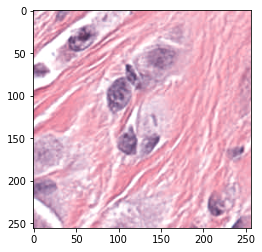

In [4]:
images, segs = next(ds_train.as_numpy_iterator())
plt.imshow(images[0,...])

In [5]:
def rotate_batch(images, angle=90):
    output = np.zeros_like(images)
    for n in range(images.shape[0]):
        output[n, ...] = rotate(images[n, ...], angle=angle, reshape=False)
    return output


In [14]:
model = get_model(
    model_name="BispectUnet",
    output_channels=3,
    n_harmonics=4,
    n_feature_maps=[8, 16, 32],
    radial_profile_type="disks",
)


In [15]:
x, y = next(ds_train.as_numpy_iterator())


In [16]:
y_pred = model(x)

In [17]:
model.summary()

Model: "bispect_unet_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_6 (Sequential)    (4, 126, 126, 8)          832       
_________________________________________________________________
sequential_7 (Sequential)    (4, 61, 61, 16)           3408      
_________________________________________________________________
sequential_8 (Sequential)    (4, 57, 57, 32)           13216     
_________________________________________________________________
sequential_9 (Sequential)    (4, 110, 110, 32)         22432     
_________________________________________________________________
sequential_10 (Sequential)   (4, 216, 216, 16)         8016      
_________________________________________________________________
sequential_11 (Sequential)   (4, 216, 216, 3)          51        
_________________________________________________________________
cropping2d_2 (Cropping2D)    multiple               

In [18]:
model.load_weights(
    "/home/valentin/python_wkspce/2d_bispectrum_cnn/models/MoNuSeg/BispectUnet__rotation_True__nh_4__n_train_-1__psize_60x60__20211212-222233/weights/split_0/final"
)


In [19]:
x_rotated = rotate_batch(x, angle=90)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


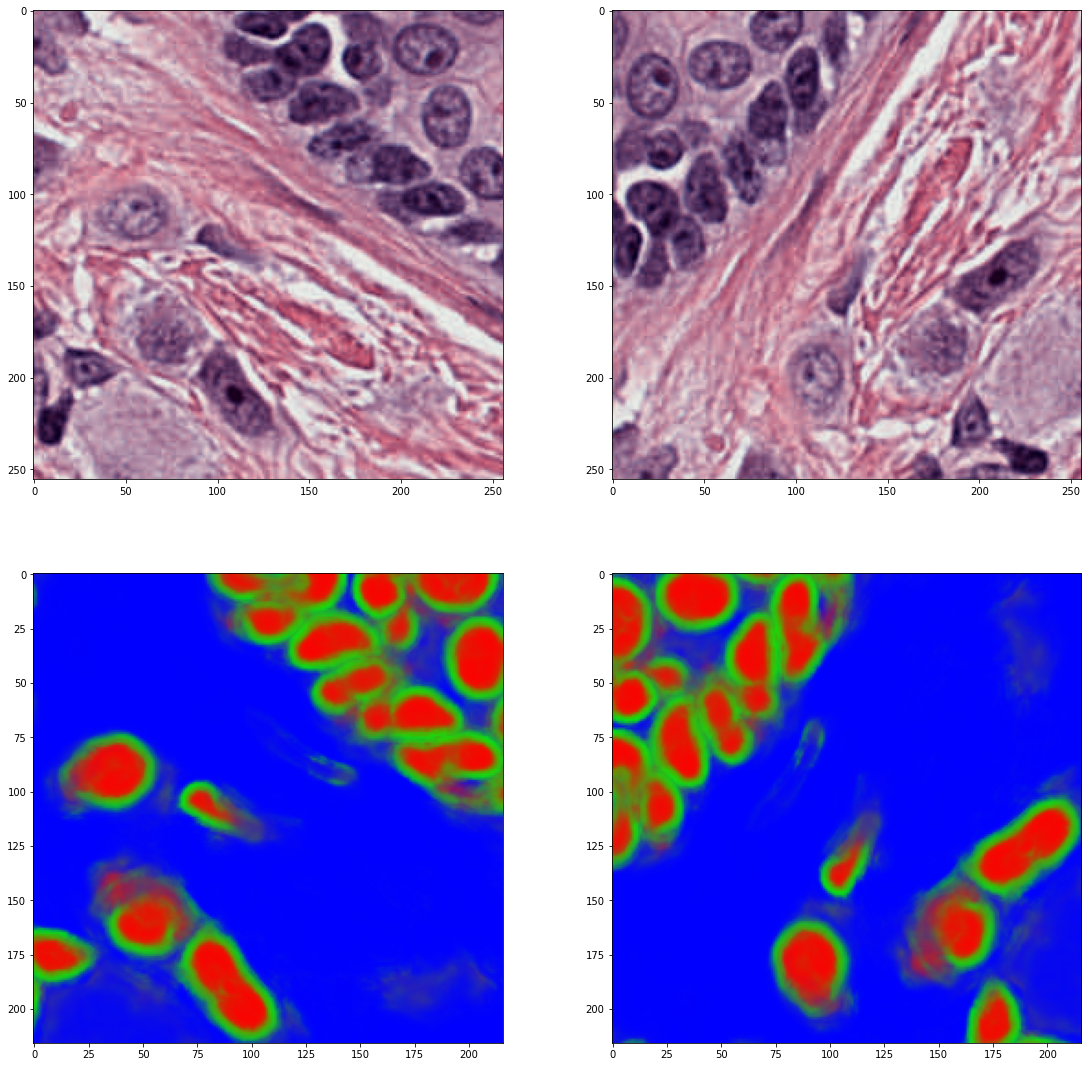

In [20]:
plt.figure(figsize=(19, 19))
plt.subplot(221)
plt.imshow(x[0, ...])
plt.subplot(222)
plt.imshow(x_rotated[0, ...])
plt.subplot(223)
plt.imshow((model(x))[0, :, :, :])
plt.subplot(224)
plt.imshow((model(x_rotated))[0, :, :, :])


In [21]:
np.min(model(x))

4.1833373e-05

In [22]:
y_diff = model(x) - rotate_batch(model(x_rotated), angle=-90)

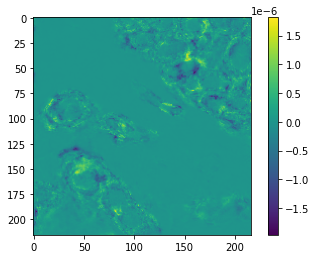

In [23]:
plt.imshow(y_diff[0,:,:,1])
plt.colorbar()

In [24]:
unet = get_model(
    model_name="Unet",
    output_channels=3,
    n_feature_maps=[8, 16, 32],
)


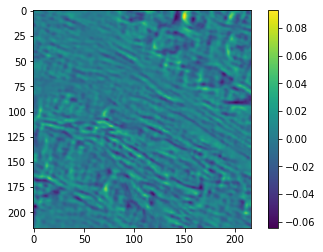

In [25]:
y_diff = unet(x) - rotate_batch(unet(x_rotated), angle=-90)
plt.imshow(y_diff[0, ..., 0])
plt.colorbar()

In [26]:
unet.load_weights(
    "/home/valentin/python_wkspce/2d_bispectrum_cnn/models/MoNuSeg/Unet__rotation_True__nh_0__n_train_-1__psize_60x60__20211130-080306/weights/split_2/final"
)


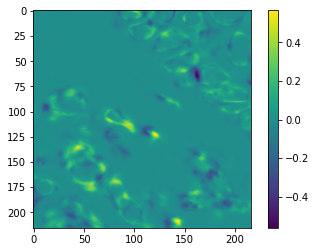

In [27]:
y_diff = unet(x) - rotate_batch(unet(x_rotated), angle=-90)
plt.imshow(y_diff[0, ..., 0])
plt.colorbar()

In [29]:
f = model.down_block_1.get_layer(index=0).conv_ch.filters.numpy()
f.shape

(5, 5, 3, 8, 4)

NameError: name 'radial_profile' is not defined

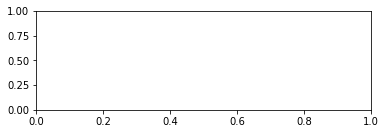

In [30]:
plt.subplot(211)
plt.imshow(radial_profile[:, :, 0])
plt.subplot(212)
plt.imshow(radial_profile[:, :, 1])


In [31]:
model.down_block_1.get_layer(index=0).indices

ListWrapper([(0, 0), (0, 1), (0, 2), (0, 3), (1, 1), (1, 2)])

In [32]:
model_2 = get_model(
    model_name="BispectUnet",
    output_channels=3,
    n_harmonics=5,
    n_feature_maps=[10, 20, 40],
    radial_profile_type="disks",
)


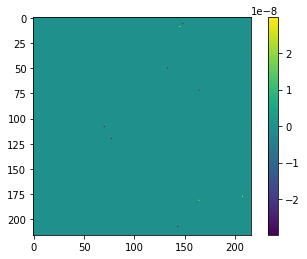

In [33]:
y_diff = model_2(x) - rotate_batch(model_2(x_rotated), angle=-90)
plt.imshow(y_diff[0, ..., 1])
plt.colorbar()

In [ ]:
indices = model_2.down_block_1.get_layer(index=0).indices

In [ ]:
len(indices)

In [ ]:
indices